# Make classification data and get it ready

In [14]:
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

Let's keep following the data explorer's motto of visualize, visualize, visualize and put them into a pandas DataFrame.

In [15]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


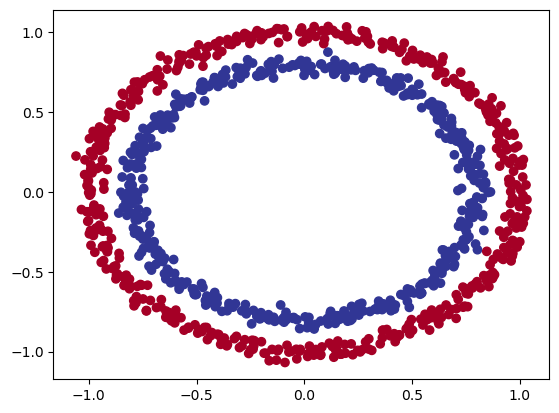

In [16]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu); # colormap


In [17]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [18]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

print("x_train size:", len(X_train), "y_test size :", len(y_test),"X_test size:", len(X_test), "y_test size:", len(y_test))


x_train size: 800 y_test size : 200 X_test size: 200 y_test size: 200


In [19]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [20]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
       # create model for binary classification
        self.normalize = nn.BatchNorm1d(2)
        self.layer_1 = nn.Linear(2, 100) # input layer 
        self.layer_2 = nn.Linear(100, 100)
        self.layer_3 = nn.Linear(100, 50)
        self.layer_4 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()
        

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        x = self.normalize(x)
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        x = torch.relu(self.layer_3(x))
        x = self.layer_4(x)
        return self.sigmoid(x)
# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (normalize): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_1): Linear(in_features=2, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=50, bias=True)
  (layer_4): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [21]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCELoss()

# Create an optimizer
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)


In [22]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [23]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 500
model_0 = CircleModelV0().to(device)


loss_fn = nn.BCELoss()
# Create an optimizer
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.0001)

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round((y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(test_logits)
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69364, Accuracy: 47.88% | Test loss: 0.69334, Test acc: 50.00%
Epoch: 50 | Loss: 0.68558, Accuracy: 50.00% | Test loss: 0.68732, Test acc: 50.00%
Epoch: 100 | Loss: 0.67195, Accuracy: 50.00% | Test loss: 0.67641, Test acc: 50.00%


Epoch: 150 | Loss: 0.63890, Accuracy: 68.50% | Test loss: 0.64732, Test acc: 64.50%
Epoch: 200 | Loss: 0.57379, Accuracy: 96.75% | Test loss: 0.58918, Test acc: 94.50%
Epoch: 250 | Loss: 0.47144, Accuracy: 99.62% | Test loss: 0.49621, Test acc: 97.00%
Epoch: 300 | Loss: 0.35363, Accuracy: 99.88% | Test loss: 0.38525, Test acc: 98.00%
Epoch: 350 | Loss: 0.24698, Accuracy: 99.88% | Test loss: 0.28165, Test acc: 99.50%
Epoch: 400 | Loss: 0.16756, Accuracy: 100.00% | Test loss: 0.20190, Test acc: 99.50%
Epoch: 450 | Loss: 0.11472, Accuracy: 100.00% | Test loss: 0.14705, Test acc: 100.00%
